In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [5]:
times, all_fluxes, spotless_lc = np.loadtxt('ring.txt', unpack=True)

In [6]:
from batman import TransitParams
params = TransitParams()
params.per = 4.049959
params.t0 = 0
params.inc = 90
params.a = 39.68
params.rp = (0.3566/100)**0.5
params.limb_dark = 'quadratic'
params.u = [0.2, 0.1]
params.w = 90
params.ecc = 0

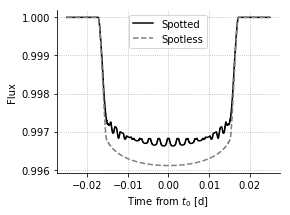

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(times, all_fluxes, color='k', label='Spotted')
ax.plot(times, spotless_lc, color='gray', ls='--', label='Spotless')
ax.legend()
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
ax.grid(ls=':')
ax.set(xlabel='Time from $t_0$ [d]', ylabel='Flux')
fig.savefig('transit_quad.pdf', bbox_inches='tight')

In [36]:
from copy import deepcopy
import batman

def transit_model(theta, x):
    r0, r1, lnf = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    
    m = batman.TransitModel(trial_params, x, exp_time=x[1]-x[0], supersample_factor=2)
    fluxes = m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, lnf = theta
    model = transit_model(theta, x) 
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((model - y)**2 *inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    r0, r1, lnf = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 3, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
yerr = np.ones_like(all_fluxes) * all_fluxes.std()/10
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=4)

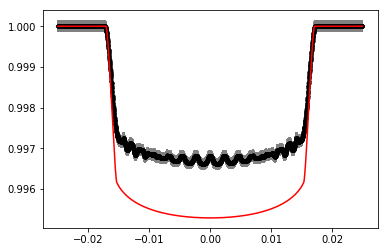

In [13]:
init_f = transit_model([params.rp*0.9, params.rp*1.1, 10], times)

plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [45]:
sampler.run_mcmc(pos, 10000); 

In [46]:
# from corner import corner

# nburnin = 5000
# corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-1)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$']);
# plt.savefig('corner_quad.pdf', bbox_inches='tight')

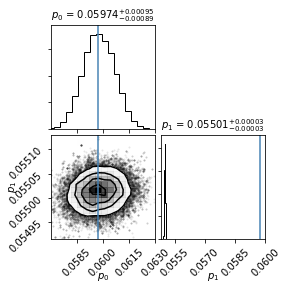

In [54]:
from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-1)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.5f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.0570, 0.063])
    if i == 3: 
        axis.set_xlim([0.0548, 0.06])
plt.savefig('corner_quad.pdf', bbox_inches='tight')

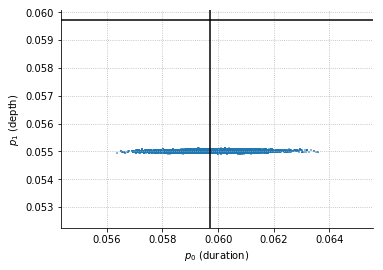

In [26]:
plt.scatter(sampler.chain[:, 5000:, 0], sampler.chain[:, 5000:, 1], marker=',', 
            s=1, alpha=0.5, rasterized=True)
plt.axvline(params.rp, color='k')
plt.axhline(params.rp, color='k')

ax = plt.gca()

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

ax.set_aspect(1)
ax.grid(ls=':')
ax.set(xlabel='$p_0$ (duration)', ylabel='$p_1$ (depth)')
plt.savefig('depth_posterior.pdf', dpi=250, bbox_inches='tight')

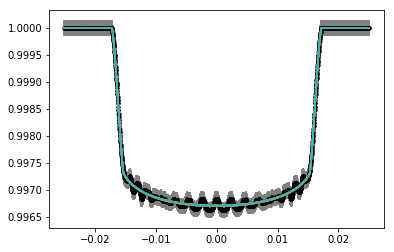

In [17]:
plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray', zorder=-10)


for i in np.random.randint(5000-sampler.chain.shape[0], size=10):
    samples_i = sampler.chain[:, (5000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))

In [1]:
yerr = np.ones_like(all_fluxes) * all_fluxes.std()/10
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, spotless_lc, yerr),
                                threads=4)

NameError: name 'np' is not defined

In [2]:
sampler2.run_mcmc(pos, 5000); 

NameError: name 'sampler2' is not defined

In [3]:
# from corner import corner

# nburnin = 5000
# corner(sampler2.chain[:, 2000:, :2].reshape((-1, ndim-1)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$']);
# plt.savefig('corner_quad_spotless.pdf', bbox_inches='tight')

from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler2.chain[:, 2000:, :2].reshape((-1, ndim-1)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.5f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.0570, 0.063])
    if i == 3: 
        axis.set_xlim([0.05966, 0.05981])
plt.savefig('corner_quad_spotless_2.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

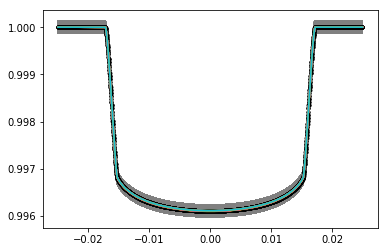

In [40]:
plt.errorbar(times, spotless_lc, yerr, fmt='.', color='k', ecolor='gray', zorder=-10)

for i in np.random.randint(2000-sampler2.chain.shape[0], size=10):
    samples_i = sampler2.chain[:, (2000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))